## 분류 모델의 가장 대표적인 활용방법중 하나 - 감성분류
## : 문서를 긍정의견 또는 부정의견으로 나누어 분류하는 것

## 크롤링 : 카카오맵 리뷰 크롤링

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
from selenium import webdriver
from bs4 import BeautifulSoup
import re
import time

excutable_path = 'C:/Users/Flora/chromedriver.exe'

source_url = "https://map.kakao.com/"

driver = webdriver.Chrome(executable_path=excutable_path)
driver.get(source_url)

searchbox = driver.find_element_by_xpath("//input[@id='search.keyword.query']")
searchbox.send_keys("사림동 파스타") #검색창 이용

searchbutton = driver.find_element_by_xpath("//button[@id='search.keyword.submit']") #검색버튼 누름
driver.execute_script("arguments[0].click();", searchbutton)

time.sleep(2) #기다리기

html = driver.page_source #결과소스

soup = BeautifulSoup(html, "html.parser")
moreviews = soup.find_all(name="a", attrs={"class":"moreview"})

page_urls = []
for moreview in moreviews:
    page_url = moreview.get("href")
    print(page_url)
    page_urls.append(page_url)

driver.close()

https://place.map.kakao.com/1085488633
https://place.map.kakao.com/19330674
https://place.map.kakao.com/1599632752
https://place.map.kakao.com/27154260
https://place.map.kakao.com/735521393
https://place.map.kakao.com/507020973
https://place.map.kakao.com/857802777
https://place.map.kakao.com/1917702756
https://place.map.kakao.com/15593460
https://place.map.kakao.com/1516841254
https://place.map.kakao.com/1084834928
https://place.map.kakao.com/27349634
https://place.map.kakao.com/1273859522
https://place.map.kakao.com/25689633
https://place.map.kakao.com/2101929906


In [3]:
columns = ['score', 'review']
df = pd.DataFrame(columns=columns)

driver = webdriver.Chrome(executable_path=excutable_path)  # for Windows
for page_url in page_urls:
    
    driver.get(page_url) #상세보기 페이지
    time.sleep(2)
    
    html = driver.page_source #첫페이지
    soup = BeautifulSoup(html, 'html.parser')
    contents_div = soup.find(name="div", attrs={"class":"evaluation_review"})
    
    #별점
    rates = contents_div.find_all(name="em", attrs={"class":"num_rate"})
    
    #리뷰
    reviews = contents_div.find_all(name="p", attrs={"class":"txt_comment"})
    
    for rate, review in zip(rates, reviews):
        row = [rate.text[0], review.find(name="span").text]
        series = pd.Series(row, index=df.columns)
        df = df.append(series, ignore_index=True)
    
    for button_num in range(2, 5):
        try:
            another_reviews = driver.find_element_by_xpath("//a[@data-page='" + str(button_num) + "']")
            another_reviews.click()
            time.sleep(2)
            
            #리뷰페이지
            html = driver.page_source
            soup = BeautifulSoup(html, 'html.parser')
            contents_div = soup.find(name="div", attrs={"class":"evaluation_review"})

            #별점
            rates = contents_div.find_all(name="em", attrs={"class":"num_rate"})

            #리뷰
            reviews = contents_div.find_all(name="p", attrs={"class":"txt_comment"})

            for rate, review in zip(rates, reviews):
                row = [rate.text[0], review.find(name="span").text]
                series = pd.Series(row, index=df.columns)
                df = df.append(series, ignore_index=True)
        except:
            break    
driver.close()

In [4]:
# 4점 이상의 리뷰는 긍정 리뷰, 3점 이하의 리뷰는 부정 리뷰
df['y'] = df['score'].apply(lambda x: 1 if float(x) > 3 else 0)
print(df.shape)
df.head()

(51, 3)


,score,review,y
0,5,맛있었어요. 웨이팅이 꽤 있어요,1
1,5,파스타 리조또 맛있어요.,1
2,5,,1
3,5,소문대로 맛있어용,1
4,5,,1


In [5]:
df.to_csv("review_data.csv", index=False)

# 텍스트 전처리 :  분류모델 피처로 변환하기

In [6]:
df = pd.read_csv("review_data.csv")

In [7]:
import re

def text_cleaning(text): #한글만 추출
    hangul = re.compile('[^ ㄱ-ㅣ가-힣]+')
    result = hangul.sub('',str(text)) #str 안해줘서 실행 안됐었음
    return result

In [8]:
df = pd.read_csv("review_data.csv")
df['ko_text'] = df['review'].apply(lambda x: text_cleaning(x))
del df['review']

df = df[df['ko_text'].str.len() > 0]
df.head()

,score,y,ko_text
0,5,1,맛있었어요 웨이팅이 꽤 있어요
1,5,1,파스타 리조또 맛있어요
3,5,1,소문대로 맛있어용
5,5,1,진짜 리얼 이탈리안가정식 인테리어도 예쁘고 무엇보다도 너무 맛있어요 재방문 의사 퍼
7,5,1,버섯샐러드 맛있음


## 형태소 단위의 추출함수 정의하기

In [9]:
from konlpy.tag import Okt

# konlpy 라이브러리로 텍스트데이터에서 형태소 추출
# : 한국어 형태소 추출 라이브러리

def get_pos(x):
    tagger = Okt()
    pos = tagger.pos(x)
    pos = ['{}/{}'.format(word, tag) for word, tag in pos]
    return pos

result = get_pos(df['ko_text'].values[0])
print(result)

#  No JVM shared library file (jvm.dll) found. Try setting up the JAVA_HOME environment variable properly.오류떠서 
#  자바 다시 설치하고 jvm.dll JAVA_HOME으로 환경설정 다시해서 해결

['맛있었어요/Adjective', '웨이팅/Noun', '이/Josa', '꽤/Noun', '있어요/Adjective']


In [10]:
from sklearn.feature_extraction.text import CountVectorizer

# 형태소를 학습데이터셋으로 변환
index_vectorizer = CountVectorizer(tokenizer = lambda x: get_pos(x))
X = index_vectorizer.fit_transform(df['ko_text'].tolist())
print(X.shape)

(42, 433)


In [11]:
print(str(index_vectorizer.vocabulary_)[:100]+"..")

{'맛있었어요/Adjective': 131, '웨이팅/Noun': 290, '이/Josa': 299, '꽤/Noun': 46, '있어요/Adjective': 321, '파스타/No..


In [12]:
print(df['ko_text'].values[0])
print(X[0])

맛있었어요 웨이팅이 꽤 있어요 
  (0, 131)	1
  (0, 290)	1
  (0, 299)	1
  (0, 46)	1
  (0, 321)	1


In [13]:
from sklearn.feature_extraction.text import TfidfTransformer

# TF-IDF 방법
# 형태소를학습 데이터셋으로 변환
tfidf_vectorizer = TfidfTransformer()
X = tfidf_vectorizer.fit_transform(X)

In [14]:
print(X.shape)
print(X[0])

(42, 433)
  (0, 321)	0.49374071919988577
  (0, 299)	0.26655956699765954
  (0, 290)	0.44452930595626516
  (0, 131)	0.49374071919988577
  (0, 46)	0.49374071919988577


# 분류 : 긍정/부정 리뷰 분류하기

In [89]:
df['y'].value_counts()

1    26
0    16
Name: y, dtype: int64

In [90]:
df = df.reset_index(drop = True, inplace = False)

In [91]:
# X = X.reshape(X.shape[0:])

In [92]:
X.shape

(42, 433)

In [93]:
# X = X.transpose()

In [94]:
# X.shape

In [95]:
from sklearn.model_selection import train_test_split

positive_random_idx = df[df['y'] == 1].sample(21, random_state = 10, replace=True).index.tolist()
negative_random_idx = df[df['y'] == 0].sample(21, random_state = 10, replace=True).index.tolist()


random_idx = positive_random_idx + negative_random_idx
print(random_idx)
sample_X = X[random_idx, :]
y = df['y'][random_idx]

# y = df['y']
# x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.30)
# print(x_train.shape)
# print(x_test.shape)

[11, 4, 20, 0, 23, 41, 21, 23, 9, 11, 0, 12, 9, 31, 4, 25, 21, 4, 20, 13, 31, 33, 38, 19, 40, 6, 10, 36, 37, 33, 38, 6, 38, 10, 35, 28, 33, 6, 35, 28, 26, 19]


In [96]:
y.shape

(42,)

In [97]:

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.28)
print(x_train.shape)
print(x_test.shape)


(30, 433)
(12, 433)


In [98]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 로지스틱 회귀모델
lr = LogisticRegression(random_state=0)
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
y_pred_probability = lr.predict_proba(x_test)[:,1]

# 성능 평가
print("accuracy: %.2f" % accuracy_score(y_test, y_pred))
print("Precision : %.3f" % precision_score(y_test, y_pred))
print("Recall : %.3f" % recall_score(y_test, y_pred))
print("F1 : %.3f" % f1_score(y_test, y_pred))

accuracy: 0.58
Precision : 0.600
Recall : 0.500
F1 : 0.545


In [99]:
from sklearn.metrics import confusion_matrix

confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[4 2]
 [3 3]]


In [100]:
df['y'].value_counts()

1    26
0    16
Name: y, dtype: int64

AUC : 0.458


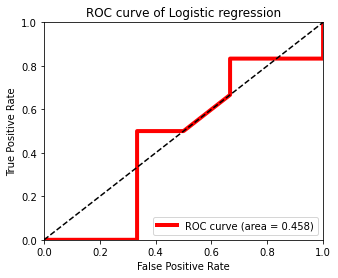

In [101]:
from sklearn.metrics import roc_curve, roc_auc_score

# AUC를 계산합니다.
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_probability)
roc_auc = roc_auc_score(y_test, y_pred_probability)
print("AUC : %.3f" % roc_auc)

# ROC curve 그래프를 출력합니다.
plt.rcParams['figure.figsize'] = [5, 4]
plt.plot(false_positive_rate, true_positive_rate, label='ROC curve (area = %0.3f)' % roc_auc, 
         color='red', linewidth=4.0)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of Logistic regression')   
plt.legend(loc="lower right")

# 중요키워드 분석

<BarContainer object of 433 artists>

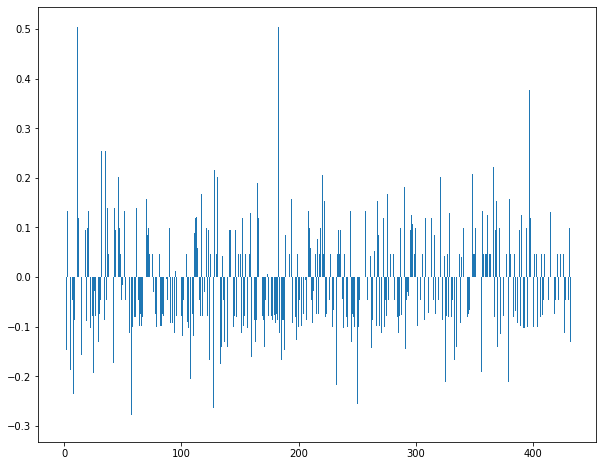

In [102]:
# 학습한 회귀 모델의 계수를 출력합니다.
plt.rcParams['figure.figsize'] = [10, 8]
plt.bar(range(len(lr.coef_[0])), lr.coef_[0])

In [103]:
print(sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse=True)[:5])
print(sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse=True)[-5:])

[(0.5047127948571728, 183), (0.5047127948571728, 11), (0.37704083601113997, 397), (0.2532503000105949, 35), (0.2532503000105949, 32)]
[(-0.256168862269268, 250), (-0.26247823755348826, 405), (-0.26353473055475524, 127), (-0.2779281160001119, 57), (-0.2920830798060436, 68)]


In [104]:
coef_pos_index = sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse=True)

In [105]:
invert_index_vectorizer = {v: k for k, v in index_vectorizer.vocabulary_.items()}
print(str(invert_index_vectorizer)[:100]+'..')

{131: '맛있었어요/Adjective', 290: '웨이팅/Noun', 299: '이/Josa', 46: '꽤/Noun', 321: '있어요/Adjective', 397: '파..


In [106]:
for coef in coef_pos_index[:20]:
    print(invert_index_vectorizer[coef[1]], coef[0])

비/Noun 0.5047127948571728
가성/Noun 0.5047127948571728
파스타/Noun 0.37704083601113997
그저/Adverb 0.2532503000105949
그래요/Adjective 0.2532503000105949
짱짱맨/Noun 0.22148639797888806
맛있어요/Adjective 0.21494965916593978
좋아요/Adjective 0.20712269887905968
식전/Noun 0.20673812319398116
있어요/Adjective 0.20249843320843325
맛있었어요/Adjective 0.20249843320843325
꽤/Noun 0.20249843320843325
별로/Noun 0.19039883265044943
웨이팅/Noun 0.18231530127239456
오일/Noun 0.16767611182621706
만/Josa 0.16767611182621706
친절합니다/Adjective 0.15683353970411412
사장/Noun 0.15683353970411412
님/Suffix 0.15683353970411412
최고/Noun 0.15425154548074713


In [107]:
for coef in coef_pos_index[-20:]:
    print(invert_index_vectorizer[coef[1]], coef[0])

감사합니다/Verb -0.1573816881278893
버섯/Noun -0.16058475022061272
적고/Verb -0.16753175621769373
비싸요/Adjective -0.16753175621769373
맛있는데/Adjective -0.16753175621769373
까지/Josa -0.1732257805109217
맛있음/Adjective -0.17532407428245203
가/Josa -0.18626827017673256
주차장/Noun -0.19026896362400264
고/Josa -0.19342146236659413
로제/Noun -0.20506998427297443
친절함/Adjective -0.21133260210829513
작음/Adjective -0.21133260210829513
아쉽/Adjective -0.21701736036834932
가격/Noun -0.23612413833404225
양/Noun -0.256168862269268
피자/Noun -0.26247823755348826
맛있어/Adjective -0.26353473055475524
너무/Adverb -0.2779281160001119
는/Josa -0.2920830798060436
